# S1 - Federated Learning for IoT and Smart Cities

## Code Structure

1. Setup enviroment by importing libs and dataset
2. Preprocess the data by
- Flatten the data
- Selects clients (if needed)
- Batch and create dict
3. Prepare the model
- Keras model 
- Create layers
- Cast keras model to tff-model
4. Build and test FL algorithm
- Initialization of model on server.
Then as a "loop" :
- server-to-client broadcast step.
- local client update step.
- client-to-server upload step.
- server update step

### 1. Setup enviroment & load dataset

In [19]:
#Reset all variables from previous run
%reset -f

Import libraries

In [1]:
#Import pyplot for plotting evaluation of model
from matplotlib import pyplot
import nest_asyncio
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff # this might register as non-resolved but seems to work

#Set seed for randomizer, to get consistent results over multiple runs (TEST IF THIS WORKS!?)
np.random.seed(0)
nest_asyncio.apply()

# # Test code for checking that tff loaded properly
# tff.federated_computation(lambda: 'Hello, World!')()

2021-12-27 12:15:11.788229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-27 12:15:11.791414: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Load the EMNIST data set of 3383 users, split into training and test sets.

The data split is approximately 89,3 % training and 10,7% test. (341 873 vs 40 832 examples, to be exact)

In [2]:
#Load EMNIST dataset of 3383 users 
# (OBS! 'dummy' is not used in code, only there since the load_data function always returns a tuple)
emnist_dataset, dummy = tff.simulation.datasets.emnist.load_data()

2021-12-27 12:15:55.871730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-27 12:15:55.871794: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-27 12:15:55.874037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-5B2NUIL3): /proc/driver/nvidia/version does not exist
2021-12-27 12:15:55.877996: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


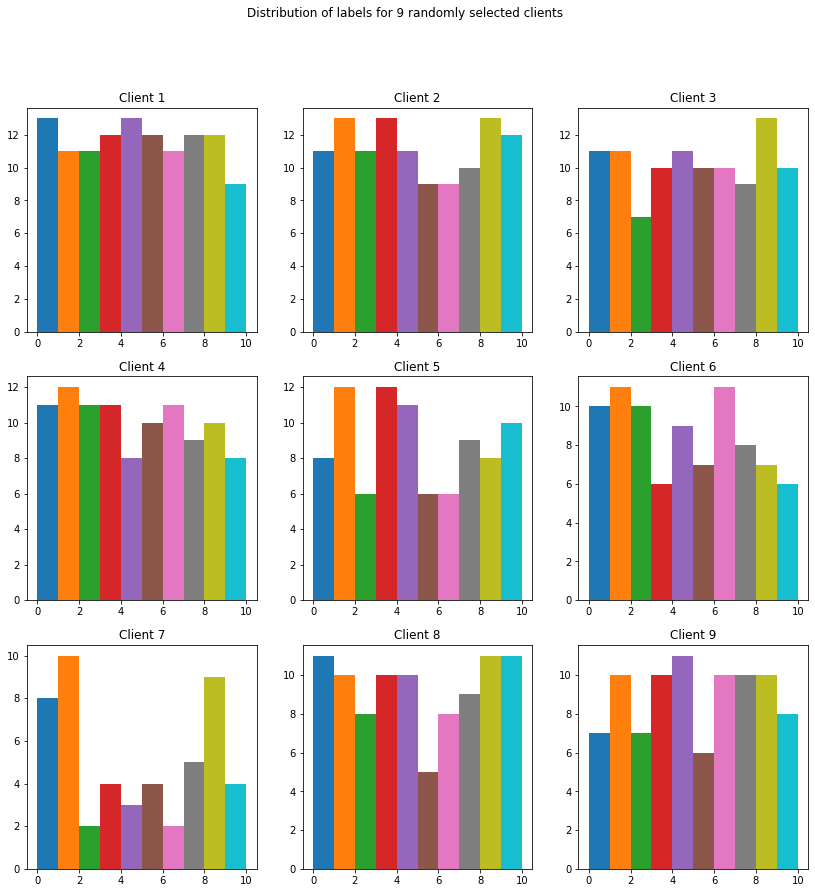

In [19]:
import collections
# Number of examples per layer for a sample of clients
f = pyplot.figure(figsize=(14, 14))
#f.suptitle('Distribution of labels for 9 randomly selected clients')
for i in range(9):
  client_dataset = emnist_dataset.create_tf_dataset_for_client(
      emnist_dataset.client_ids[i+100])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  pyplot.subplot(3, 3, i+1)
  pyplot.title('Client {}'.format(i+1))
  for j in range(10):
    pyplot.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        range=(0,14),
        histtype='stepfilled')

### 2. Process the data

Set some model parameters

In [22]:
#How many of the 3383 clients to use for training and testing, respectively
NUM_TRAIN_CLIENTS = 10
NUM_TEST_CLIENTS = 5
#The batch size used in training
BATCH_SIZE = 5
#Number of rounds to run the algorithm
ROUNDS = 100


Flatten batches of data, and conver to a tuple (flattened_image_vector, label)

In [23]:
# Function for preprocessing the dataset
def preprocess(dataset):
  # Function for flattening a batch of EMNIST data, and returning a (features, label) tuple
  def batch_format_fn(element):
    return (tf.reshape(element['pixels'], [-1, 784]), 
            tf.reshape(element['label'], [-1, 1]))
  #Return flattened and batched data
  return dataset.batch(BATCH_SIZE).map(batch_format_fn)

Split clients into separate train and test groups, and then load data for these groups

In [24]:
#Split the clients into train and test groups, with no overlap
training_dataset, test_dataset = emnist_dataset.train_test_client_split(client_data=emnist_dataset, num_test_clients=NUM_TEST_CLIENTS)

#Store the client IDs of the clients to be used for training
client_ids_train = sorted(training_dataset.client_ids)[:NUM_TRAIN_CLIENTS]

#Create training data by preprocessing dataset for clients in training set
federated_train_data = [preprocess(emnist_dataset.create_tf_dataset_for_client(x))
  for x in client_ids_train
]

#Create central evaluation dataset by preprocessing a single dataset for all clients in test set 
central_emnist_test = test_dataset.create_tf_dataset_from_all_clients()
central_emnist_test = preprocess(central_emnist_test)

## 3. Preparing the model

Create a keras ML model, with one hidden layer and a softmax layer

In [25]:
#Function for creating a keras model
def create_keras_model():
  initializer = tf.keras.initializers.GlorotNormal(seed=0)
  #Return the model
  return tf.keras.models.Sequential([
      #Input layer matches the number of pixels of images
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer=initializer),
      #Softmax layer used to calculate what number is most likely
      tf.keras.layers.Softmax(),
  ])

Wrap this model as a 'tff.learning.Model' for use in Tensorflow Federated

In [26]:
#Function for creating a TFF model
def model_fn():
  #Call on function for creating a keras model
  keras_model = create_keras_model()
  
  #Create a TFF model from this keras model, and return it
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=federated_train_data[0].element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## 4. Building our own FL algorithm

### 4.2 Client update step

Function for performing a client update

In [27]:
#TF function for performing a client update (Is in the code called by client_update_fn)
@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights.
  client_weights = model.trainable_variables
  # Assign the server weights to the client model.
  tf.nest.map_structure(lambda x, y: x.assign(y), client_weights, server_weights)

  # Use the client_optimizer to update the local model.
  for batch in dataset:
    with tf.GradientTape() as tape:
      # Compute a forward pass on the batch of data
      outputs = model.forward_pass(batch)

    # Compute the corresponding gradient
    grads = tape.gradient(outputs.loss, client_weights)
    grads_and_vars = zip(grads, client_weights)

    # Apply the gradient using a client optimizer.
    client_optimizer.apply_gradients(grads_and_vars)
  #Return the new weights of the client model
  return client_weights

### 4.4 Server update step

A simple "FedAvd" update (aka "vanilla FL")

In [28]:
# TF function for perfoming a server update (Is in the code called by server_update_fn)
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  model_weights = model.trainable_variables
  # Assign the mean client weights to the server model.
  tf.nest.map_structure(lambda x, y: x.assign(y), model_weights, mean_client_weights)
  return model_weights

### Federated core

In summary:

TFF operates on federated values.
Each federated value has a federated type, with a type (eg. tf.float32) and a placement (eg. tff.CLIENTS).
Federated values can be transformed using federated computations, which must be decorated with tff.federated_computation and a federated type signature.
TensorFlow code must be contained in blocks with tff.tf_computation decorators.
These blocks can then be incorporated into federated computations.

## 5.

Creating a 'tf computation' and a 'federated computation' to initialize the model on the server.
(The latter makes use of the former)

In [29]:
#tf_computation for initializing the model
@tff.tf_computation
def server_init():
  model = model_fn()
  return model.trainable_variables

#federated_computation for initializing the model (Calls on the above created server_init)
@tff.federated_computation
def initialize_fn():
  return tff.federated_value(server_init(), tff.SERVER)

### Client update

Get datatype of dataset and model weights

In [30]:
# Create a temporary model
whimsy_model = model_fn()
# Use temporary model to see what datatypes the dataset and model weights will be
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)
model_weights_type = server_init.type_signature.result

Create a (tf computation) function for performing a client update, using SGD

In [31]:
# Function for client update
@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  #Create a model to perform training on
  model = model_fn()
  #Create a SGD optimizer, with learning rate = 0.01
  client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
  
  #Perform the client update (using a previously defined function), and return the resulting client weights
  return client_update(model, tf_dataset, server_weights, client_optimizer)


Create a (tf computation) function for performing the server update, using FedAvg

In [32]:
#Function for server update
@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
  #Create a model
  model = model_fn()

  #Perform the server update with FedAvg (using a previously defined function), and return the updated model weights
  return server_update(model, mean_client_weights)

Create a function for iterating one step in the FL algorithm.

In [33]:
#Create federated types for server and clients, used to define input data type for federated computation below
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

#Function for the four steps to be performed iteratively in the FL algorithm
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):

  # The server model weights are broadcasted to the clients
  server_weights_at_client = tff.federated_broadcast(server_weights)

  # Each client computes their updated model weights, using SGD
  client_weights = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))
  
  # The server calculates the average of the client updates, using FedAvg
  mean_client_weights = tff.federated_mean(client_weights)

  # The server updates its model with these averaged weights
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)
  return server_weights

Create the federated algorithm, in the form of a tff iterative process

In [34]:
#Create the federated algorithm as an "IterativeProcess"
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

Create a evaluation function using keras

In [35]:
#Function for evaluating the current model, using the test dataset
def evaluate(server_state):
  #Create a model
  keras_model = create_keras_model()
  #Define the loss and metrics to be used
  keras_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()] 
  )
  #Set model to have the weights that the server currently has
  keras_model.set_weights(server_state)
  #Use model on the test set to evaluate it, and return the results
  results = keras_model.evaluate(central_emnist_test)
  return results

## MAIN LOOP OF THE FL SYSTEM

In [38]:
# Initialize FL model
server_state = federated_algorithm.initialize()
#Evaluate and save the loss of accuracy of the model before training begins
results_list = [evaluate(server_state)]

# Perform iteration rounds for FL model 
for round in range(ROUNDS):
  server_state = federated_algorithm.next(server_state, federated_train_data)
  # Evaluate model accuracy and loss on test data every 10 rounds
  if round % 10 == 0:
    #TEST
    print("round = " + str(round))
    results_list.append(evaluate(server_state))

#Evaluate final state
results_list.append(evaluate(server_state))

108/108 [==============================] - 1s 7ms/step - loss: 2.7929 - sparse_categorical_accuracy: 0.1285
round = 0
108/108 [==============================] - 1s 7ms/step - loss: 2.8813 - sparse_categorical_accuracy: 0.1080
round = 10
108/108 [==============================] - 1s 5ms/step - loss: 2.4754 - sparse_categorical_accuracy: 0.1192
round = 20
108/108 [==============================] - 1s 5ms/step - loss: 2.1665 - sparse_categorical_accuracy: 0.1583
round = 30
108/108 [==============================] - 1s 5ms/step - loss: 1.9489 - sparse_categorical_accuracy: 0.2551
round = 40
108/108 [==============================] - 1s 5ms/step - loss: 1.7926 - sparse_categorical_accuracy: 0.3222
round = 50
108/108 [==============================] - 1s 6ms/step - loss: 1.6716 - sparse_categorical_accuracy: 0.3780
round = 60
108/108 [==============================] - 1s 8ms/step - loss: 1.5719 - sparse_categorical_accuracy: 0.4153
round = 70
108/108 [==============================] - 1s 6ms

In [ ]:
#Convert the list containing evaluation loss and accuracy to a DataFrame
import pandas as pd
results_df = pd.DataFrame(results_list,columns=['loss','accuracy'])

Plot test results in graph

In [ ]:
#Create plot for loss
fig_loss, ax_loss = pyplot.subplots()
ax_loss.plot(results_df.loss)
ax_loss.set_title('Loss')

#Create plot for sparse categorical accuracy
fig_acc, ax_acc = pyplot.subplots()
ax_acc.plot(results_df.accuracy)
ax_acc.set_title('Sparse Categorical Accuracy')